In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rakeshsuru16
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:28<00:00, 78.9MB/s]

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import librosa
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv")

data_df.head()

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [8]:

data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:]

data_df.head()

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


Data Shape is:  (6687, 2)
Claases Distrubution is: 


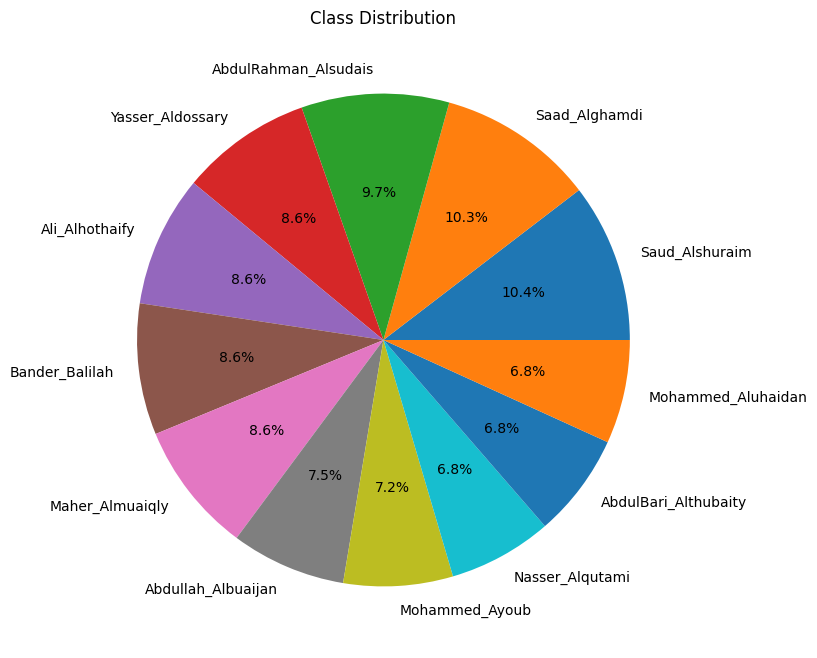

In [9]:
print("Data Shape is: ", data_df.shape)

print("Claases Distrubution is: ")

class_counts = data_df['Class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')

plt.title('Class Distribution')

plt.show()

In [12]:
label_encoder = LabelEncoder()
data_df["Class"] = label_encoder.fit_transform(data_df["Class"])

train=data_df.sample(frac=0.7,random_state=16)
test=data_df.drop(train.index)

val=test.sample(frac=0.5,random_state=16)
test=test.drop(val.index)


print("Training Shape: ", train.shape)
print("Validation Shape: ", val.shape)
print("Testing Shape: ", test.shape)

Training Shape:  (4681, 2)
Validation Shape:  (1003, 2)
Testing Shape:  (1003, 2)


In [13]:
class CustomAudioDataset(Dataset):
  def __init__(self, dataframe):
    self.dataframe = dataframe
    self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = (self.audios[idx]).unsqueeze(0).to(device)
    return audio, label

  def get_spectrogram(self, file_path):
    sr = 22050
    duration = 5

    img_height = 128
    img_width = 256

    signal, sr = librosa.load(file_path, sr=22050, duration=duration)

    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    spec_db = librosa.power_to_db(spec, ref=np.max)

    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

In [14]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [15]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear((64 * 16 * 32), 4096)
    self.linear2 = nn.Linear(4096, 1024)
    self.linear4 = nn.Linear(1024, 512)
    self.output = nn.Linear(512, len(data_df['Class'].unique()))

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device)

In [18]:
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [21]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  start_time = time.time()
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{EPOCHS},
                  Train Loss: {round(total_loss_train/100, 4)},
                  Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)},
                  Validation Loss: {round(total_loss_val/100, 4)},
                  Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)
  print("="*30)


                  Epoch: 1/25, 
                  Train Loss: 16.6317, 
                  Train Accuracy: 10.5106, 
                  Validation Loss: 1.5336, 
                  Validation Accuracy: 12.8614
                  

                  Epoch: 2/25, 
                  Train Loss: 7.0726, 
                  Train Accuracy: 12.7323, 
                  Validation Loss: 1.5043, 
                  Validation Accuracy: 15.4536
                  

                  Epoch: 3/25, 
                  Train Loss: 6.5691, 
                  Train Accuracy: 21.3416, 
                  Validation Loss: 1.3138, 
                  Validation Accuracy: 28.8136
                  

                  Epoch: 4/25, 
                  Train Loss: 5.5125, 
                  Train Accuracy: 35.8898, 
                  Validation Loss: 1.0822, 
                  Validation Accuracy: 41.2762
                  

                  Epoch: 5/25, 
                  Train Loss: 4.6307, 
                  Train

In [22]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 89.63%


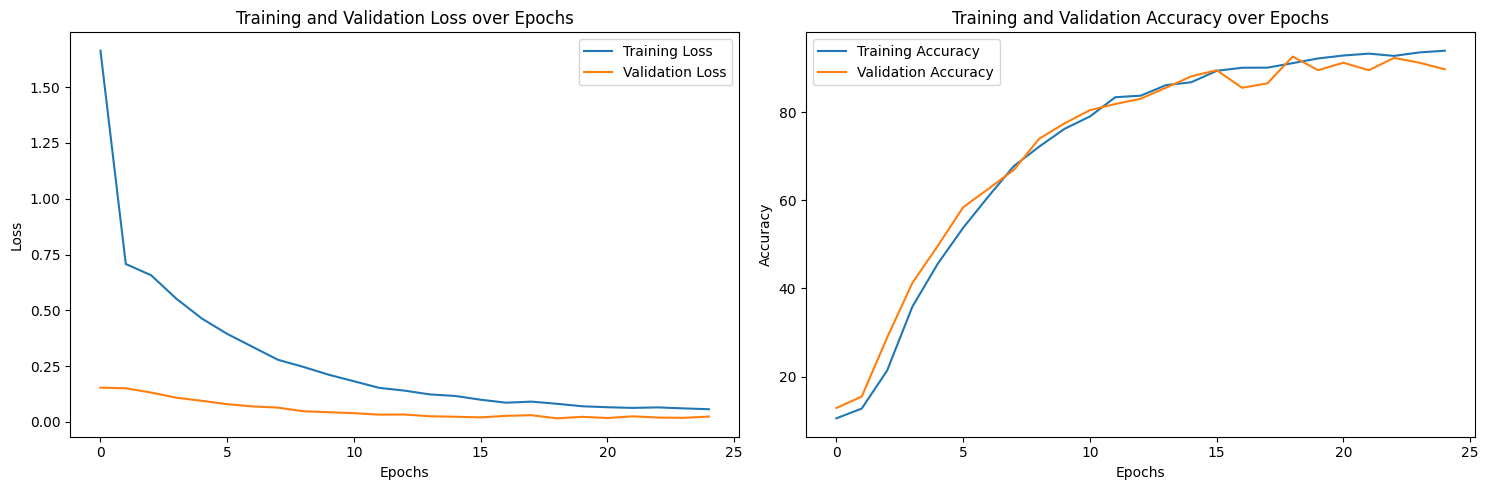

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()